In [ ]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math
import time
import tqdm
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes

In [ ]:
# configuration

starttime = time.time()
checkpointfilepath = r"checkpoints/sam_vit_h_4b8939.pth"
num_slices = 100
# transform_list = platonics.get_cube_transforms()
transform_list = platonics.get_icosahedron_transforms()

image = utils.padtocube(utils.load3dmatrix('images/I1351301'))
            
print(image.shape)

plt.imshow(image[:,:,image.shape[2]//2])
plt.show()
plt.imshow(image[:,image.shape[1]//2,:])
plt.show()
plt.imshow(image[image.shape[0]//2,:,:])
plt.show()

In [ ]:
def get_prompt_slices(image, dirpath):
    slices_list = []
    for a, t in enumerate(transform_list):
        transformed_img = scale_transform.global_to_local(image, t)
        slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
        cv2.imwrite(f'{dirpath}/slice_{str(a).zfill(2)}.png', slice_transformed_img)

        slice_info = dict()
        slice_info['idx'] = transformed_img.shape[2]//2
        slice_info['transform'] = t
        slice_info['shape'] = transformed_img.shape
        slices_list.append(slice_info)    

    return slices_list

def get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices):
    pos_seg = []
    neg_seg = []

    for i, s in enumerate(slices_list):
        idx = s['idx']
        shape = s['shape']
        transform_curr = s['transform']

        for line in pos_polylines_slices[i]:
            global_line = []
            for point in line:
                point = point[:2] + [idx]
                print(point)
                transformed_point = scale_transform.index_to_coord(point, transform_curr, shape)
                print(transformed_point)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                pos_seg.append([global_line[j], global_line[j + 1]])

        for line in neg_polylines_slices[i]:
            global_line = []
            for point in line:
                point = point[:2] + [idx]
                transformed_point = scale_transform.index_to_coord(point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                neg_seg.append([global_line[j], global_line[j + 1]])
    # return zero centric points, global matrix
    return pos_seg, neg_seg

def get_intersections(matrix_shape, pos_seg, neg_seg, t, z):
    # calculate intersection points
    pos_intersects = []
    neg_intersects = []

    for p in pos_seg:
        # zero centric points, local matrix
        # z: zero centric
        intersection = scale_transform.get_intersection_point(t.apply_to_point(p[0]), t.apply_to_point(p[1]), z)
        if intersection:
            pos_intersects.append(t.apply_to_point(intersection, inverse=True))

    for n in neg_seg:
        intersection = scale_transform.get_intersection_point(t.apply_to_point(n[0]), t.apply_to_point(n[1]), z) # z should be supplied as a global coordinate
        if intersection:
            neg_intersects.append(t.apply_to_point(intersection, inverse=True))

    # need to transform inverse right?
    # zero centric, local matrix -> matrix indexing, global
    pos_intersects = [scale_transform.coord_to_index(pt, t, matrix_shape) for pt in pos_intersects]
    neg_intersects = [scale_transform.coord_to_index(pt, t, matrix_shape) for pt in neg_intersects]
    # print(f"zero centric pos intersects: {pos_intersects}")
    # pos_intersects = [scale_transform.scale_backward(np.array(pt), matrix_shape) for pt in pos_intersects]
    # neg_intersects = [scale_transform.scale_backward(np.array(pt), matrix_shape) for pt in neg_intersects]
    # print(f"matrix indexed pos intersects: {pos_intersects}")
    return pos_intersects, neg_intersects

def normalize (image):
    if np.min(image) == np.max(image):
        return np.stack([image, image, image], axis=2)
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    stacked = np.stack([image, image, image], axis=2)
    return stacked


In [ ]:
# get prompt slices
folder = r"intermediates"


# image = utils.load3dmatrix(folder)
# print(image.shape)
# image = utils.padtocube(image)

slices_list = get_prompt_slices(image, folder)

In [ ]:
# given json with polylines
# parse
with open(folder + '/prompts.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

# get pos, neg line segments
pos_seg, neg_seg = get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices)

In [ ]:
print(pos_seg)
point = scale_transform.coord_to_index(pos_seg[0][0], transform_list[2], (220,220,220))
print(point)

In [ ]:
# initialize the model
sam_checkpoint = checkpointfilepath
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
# BIG forloop
prompting_slices_dict = dict()
count = 0
allpoints = []
boundarypoints = []

for t in tqdm.tqdm(transform_list):
    transformed_img = scale_transform.global_to_local(image, t)
    matrix_shape = np.array(transformed_img.shape)
    
    # z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:] 
    # zero centric z coord
    z_coord_list = np.linspace(-1,1, num_slices+2)[1:-1] 

    # t.plot_self()

    for z in z_coord_list:
        # get the slice of the rotated array
        zidx = int((z+1)/2 * matrix_shape[2])
        slice_transformed_img = transformed_img[:,:,zidx]
        slice_shape = slice_transformed_img.shape
        
        pos_intersects, neg_intersects = get_intersections(matrix_shape, pos_seg, neg_seg, t, z)
        # print(pos_intersects)
        # print(neg_intersects)

        # zero centric intersects
        # pos_intersects = [pt[:2] for pt in pos_intersects]
        # neg_intersects = [pt[:2] for pt in neg_intersects]
        pos_intersects = [[pt[1],pt[0]] for pt in pos_intersects]
        neg_intersects = [[pt[1],pt[0]] for pt in neg_intersects]

        if len(pos_intersects) != 0:
            prompt = [pos_intersects, neg_intersects]
            points, boundary = segmentfunction.segment(predictor, normalize(slice_transformed_img), prompt)

            # undersample points:
            # undersample = 3
            # points[1::undersample] = 0
            # points[2::undersample] = 0
            # points[:,1::undersample] = 0
            # points[:,2::undersample] = 0

            pointstobeconverted = []
            for a in range(points.shape[0]):
                for b in range(points.shape[1]):
                    if points[a,b] == 1:
                        pointstobeconverted.append([a,b,zidx])
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                allpoints.append(i)


            pointstobeconverted = []
            for a in range(boundary.shape[0]):
                for b in range(boundary.shape[1]):
                    if boundary[a,b] == 1:
                        pointstobeconverted.append([a,b,zidx])
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                boundarypoints.append(i)



In [ ]:
import open3d as o3d

In [ ]:
pcd = o3d.geometry.PointCloud()
n = np.zeros((len(allpoints), 3))
for i in range(len(allpoints)):
    n[i] = allpoints[i]
pcd.points = o3d.utility.Vector3dVector(n)
print("Time taken = ", time.time()-starttime)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

In [ ]:
# import pointcloudmeshtouse
from scipy.stats import gaussian_kde


def create_density_mask(points, resolution=50, threshold=0.8):
    """
    Create a 3D density mask from points using Gaussian KDE.
    
    Parameters:
    - points: A numpy array of shape (n, 3), representing 3D points.
    - resolution: The desired resolution for each dimension of the output grid.
    - threshold_percentile: The percentile for density thresholding to create the mask.
    
    Returns:
    - mask: A numpy array of shape (resolution, resolution, resolution), representing the 3D binary mask.
    """
    # Calculate the Gaussian KDE for the input points
    kde = gaussian_kde(points.T, bw_method=0.1)  # Transpose points to shape (3, n) for KDE
    


    # first pass
    print('first pass')
    # Generate a grid of new points within the range [-1, +1] for each dimension
    x = np.linspace(-1, 1, resolution)
    y = np.linspace(-1, 1, resolution)
    z = np.linspace(-1, 1, resolution)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    
    # Evaluate the KDE on the grid points to calculate densities
    densities = kde(grid_points).reshape(resolution, resolution, resolution)
    # Threshold the density array to create a 3D binary mask
    mask = np.where(densities > threshold, 1, 0)

    print('second pass')
    nonzeros = np.nonzero(mask)
    x_start = np.min(nonzeros[0])-1
    x_end   = np.max(nonzeros[0])+2
    y_start = np.min(nonzeros[1])-1
    y_end   = np.max(nonzeros[1])+2
    z_start = np.min(nonzeros[2])-1
    z_end   = np.max(nonzeros[2])+2
    # print(x_start, x_end, y_start, y_end, z_start, z_end)
    # print(x_start/resolution*2-1, x_end/resolution*2-1)
    x = np.linspace(x_start/resolution*2-1, x_end/resolution*2-1, resolution)
    y = np.linspace(y_start/resolution*2-1, y_end/resolution*2-1, resolution)
    z = np.linspace(z_start/resolution*2-1, z_end/resolution*2-1, resolution)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    
    # # Evaluate the KDE on the grid points to calculate densities
    densities = kde(grid_points).reshape(resolution, resolution, resolution)
    # # Threshold the density array to create a 3D binary mask
    mask = np.where(densities > threshold, 1, 0)

    return mask

def visualize_3d_mask(mask):
    print("visualizing")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate the voxel coordinates
    x, y, z = np.indices(np.array(mask.shape) + 1)
    ax.voxels(x, y, z, mask, facecolors='blue', edgecolor='k')
    ax.set_aspect('equal')
    
    plt.show()


def octtree_density_mask(pcd):
    print('octree division')
    octree = o3d.geometry.Octree(max_depth=6)
    octree.convert_from_point_cloud(pcd, size_expand=0)
    o3d.visualization.draw_geometries([octree])
    voxgrid = octree.to_voxel_grid()
    return voxgrid

def voxel_density_mask(pcd, vox_size = 0.01, resolution=64):
    print('voxelization')
    voxgrid = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(pcd, voxel_size = vox_size, min_bound = (-1,-1,-1), max_bound = (1,1,1))
    # o3d.visualization.draw_geometries([voxgrid])

    # get binary array
    x = np.linspace(-1, 1, resolution)/3**0.5
    y = np.linspace(-1, 1, resolution)/3**0.5
    z = np.linspace(-1, 1, resolution)/3**0.5
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    queries = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
    output = voxgrid.check_if_included(o3d.utility.Vector3dVector(queries))
    output = np.array(output).reshape(resolution,resolution,resolution)
    # mask processing:
    dilated = binary_dilation(output, iterations = 5)
    eroded = binary_erosion(dilated, iterations = 5)
    mask = binary_fill_holes(eroded)
    # mask = output
    return mask

In [ ]:
# densitymask = create_density_mask(np.array(allpoints))
# octtree_density_mask(pcd)
mask = voxel_density_mask(pcd, vox_size = 1/image.shape[0]*2, resolution=image.shape[0])# int(image.shape[0]*3**0.5))

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(image[128,:,:])
ax[0,1].imshow(image[:,128,:])
ax[0,2].imshow(image[:,:,128])

ax[1,0].imshow(image[128,:,:])
ax[1,0].imshow(mask[128,:,:], alpha=0.5, cmap = 'RdBu_r')
ax[1,1].imshow(image[:,128,:])
ax[1,1].imshow(mask[:,128,:], alpha=0.5, cmap = 'RdBu_r')
ax[1,2].imshow(image[:,:,128])
ax[1,2].imshow(mask[:,:,128], alpha=0.5, cmap = 'RdBu_r')

In [ ]:
utils.save_mrc(image, 'outputs/adni_brain_img.mrc')
utils.save_mrc(mask, 'outputs/adni_brain_mask_ventricles.mrc')

In [ ]:
# import plotly.graph_objects as go
# import numpy as np
# X, Y, Z = np.mgrid[:mask.shape[0], :mask.shape[1],:mask.shape[2]]
# values = mask

# fig = go.Figure(data=go.Volume(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=Z.flatten(),
#     value=values.flatten(),
#     isomin=0,
#     isomax=1.1,
#     opacity=0.2, # needs to be small to see through all surfaces
#     surface_count=20, # needs to be a large number for good volume rendering
#     ))
# fig.show()

In [ ]:
# boundary = o3d.geometry.PointCloud()
# n = np.zeros((len(boundarypoints), 3))
# for i in range(len(boundarypoints)):
#     n[i] = boundarypoints[i]
# boundary.points = o3d.utility.Vector3dVector(n)
# print("Time taken = ", time.time()-starttime)
# o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")


# boundary.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# # Optionally, you might want to orient the normals in a consistent manner, especially for visualization
# boundary.orient_normals_consistent_tangent_plane(k=10)

# poisson_mesh =o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(boundary,depth=6, width=0, scale=1.1, linear_fit=False)[0]


In [ ]:
# bbox = boundary.get_axis_aligned_bounding_box()
# print("done3")
# p_mesh_crop = poisson_mesh.crop(bbox)
# print("done4")
# o3d.visualization.draw_geometries([p_mesh_crop], window_name="Triangle Mesh")

In [1]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math
import time
import tqdm
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes

done


In [19]:
transform_list = platonics.get_icosahedron_transforms()
# transform_list = platonics.get_cube_transforms()
# transform_list = platonics.get_dodecahedron_transforms()
# transform_list = platonics.get_ortho_transforms()

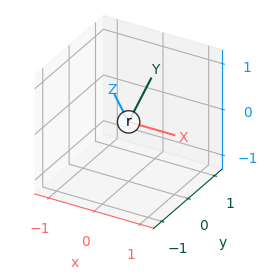

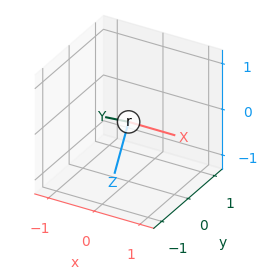

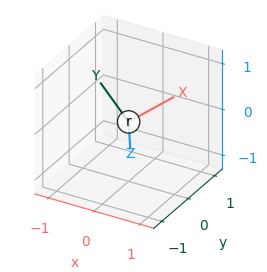

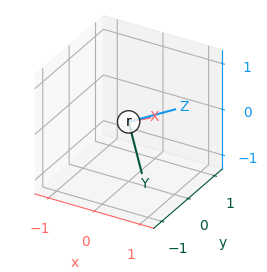

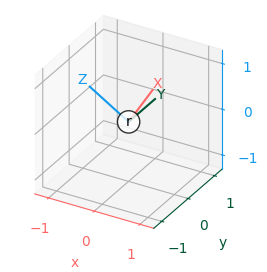

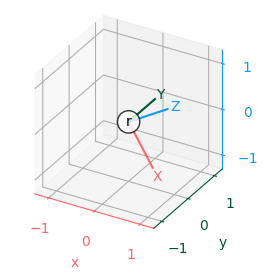

In [20]:
for transform in transform_list:
    transform.plot_self()
    print(transform)

In [21]:
testpt = [0,0,1]

transform_list[0].apply_to_point(testpt).astype(np.float16)

array([ 0.    , -0.526 ,  0.8506], dtype=float16)

In [22]:
transform_list[1].apply_to_point(testpt).astype(np.float16)

array([ 0.    , -0.526 , -0.8506], dtype=float16)

In [23]:
transform_list[2].apply_to_point(testpt).astype(np.float16)

array([ 0.526 , -0.8506,  0.    ], dtype=float16)

In [24]:
transform_list[3].apply_to_point(testpt).astype(np.float16)

array([0.526 , 0.8506, 0.    ], dtype=float16)

In [25]:
transform_list[4].apply_to_point(testpt).astype(np.float16)

array([-0.8506,  0.    ,  0.526 ], dtype=float16)

In [26]:
transform_list[5].apply_to_point(testpt).astype(np.float16)

array([0.8506, 0.    , 0.526 ], dtype=float16)

In [27]:
transform_list[6].apply_to_point(testpt).astype(np.float16)

IndexError: list index out of range

In [28]:
transform_list[7].apply_to_point(testpt).astype(np.float16)

IndexError: list index out of range

In [37]:
transform_list[8].apply_to_point(testpt).astype(np.float16)

array([ 0.357,  0.   , -0.934], dtype=float16)

In [38]:
transform_list[9].apply_to_point(testpt).astype(np.float16)

array([0.357, 0.   , 0.934], dtype=float16)